In [10]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from dimensionality_reduction import run_dimensionality_reduction, plot_embeddings

import time

# Load in and process data

In [11]:
df = pd.read_csv('./data/Sujeto1.csv')

# Save the EEG columns and MarkerValueInt column as separate arrays
eeg_columns = [f'EEG.{col}' for col in ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']]
affect_columns = [f'PM.{col}.Scaled' for col in ['Engagement', 'Excitement', 'Stress', 'Relaxation', 'Interest', 'Focus']]

marker_value_int = df['MarkerValueInt'].to_numpy()
eeg = df[eeg_columns].to_numpy()
affect = df[affect_columns].to_numpy()
occ = df[["EEG.O1", "EEG.O2"]].to_numpy()

In [12]:
def fill_and_drop(df):
    df = df.dropna(how="all")
    df = df.fillna(method='ffill')
    return df.dropna()

# eeg and marker value int as class
df_eeg = pd.DataFrame(eeg, columns=eeg_columns)
df_eeg['stimulus'] = marker_value_int
df_eeg = fill_and_drop(df_eeg)
# drop the stimulus column and convert to numpy
eeg = df_eeg.drop(columns=['stimulus']).to_numpy()

# affect and marker value int as class
df_affect = pd.DataFrame(affect, columns=affect_columns)
df_affect['stimulus'] = marker_value_int
df_affect = fill_and_drop(df_affect)
affect = df_affect.drop(columns=['stimulus']).to_numpy()

# occ and marker value int as class
df_occ = pd.DataFrame(occ, columns=["EEG.O1", "EEG.O2"])
df_occ['stimulus'] = marker_value_int
df_occ = fill_and_drop(df_occ)
occ = df_occ.drop(columns=['stimulus']).to_numpy()

# Create datasets

In [13]:
class Dataset:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

# Uses the same train/test split for all datasets, imports scikit-learn's train_test_split

def split_dataset(df):
    X = df.drop(columns=['stimulus'])
    y = df['stimulus']
    return Dataset(*train_test_split(X, y, test_size=0.3, random_state=42))

In [14]:
eeg_dataset = split_dataset(df_eeg)
affect_dataset = split_dataset(df_affect)
occ_dataset = split_dataset(df_occ)

# Set up classifiers

In [15]:
# Define the classifiers you want to test
# Define the classifiers you want to test
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Naive Bayes', GaussianNB()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('XGBoost', XGBClassifier()),
]

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', None)
])


In [16]:
def run_pipeline(dataset, pipeline, classifier_name, classifier):
    start_time = time.time()
    pipeline.set_params(classifier=classifier)

    pipeline.fit(dataset.X_train, dataset.y_train)
    y_pred = pipeline.predict(dataset.X_test)

    cm = confusion_matrix(dataset.y_test, y_pred)
    accuracy = accuracy_score(dataset.y_test, y_pred)
    precision = precision_score(dataset.y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(dataset.y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(dataset.y_test, y_pred, average='weighted', zero_division=0)
    end_time = time.time()

    return classifier_name, accuracy, precision, recall, f1, end_time - start_time


def test_classifiers(dataset, pipeline, classifiers):
    print("{:<20} {:<8} {:<8} {:<8} {:<8} {:<8}".format("Model", "Accuracy", "Precision", "Recall", "F1", "Time"))

    for classifier_name, classifier in classifiers:
        name, accuracy, precision, recall, f1, time_taken = run_pipeline(dataset, pipeline, classifier_name, classifier)
        print("{:<20} {:.3f}    {:.3f}    {:.3f}    {:.3f}    {:.3f}".format(name, accuracy, precision, recall, f1, time_taken))


# EEG and 5 Stimuli Analysis

In [9]:
test_classifiers(eeg_dataset, pipeline, classifiers)

Model                Accuracy Precision Recall   F1       Time    
Logistic Regression  0.263    0.263    0.263    0.262    0.302
K-Nearest Neighbors  0.885    0.886    0.885    0.885    7.593
Decision Tree        0.639    0.639    0.639    0.639    1.163
Random Forest        0.869    0.870    0.869    0.869    18.405
SVM                  0.467    0.480    0.467    0.467    156.094
Naive Bayes          0.223    0.282    0.223    0.143    0.067
AdaBoost             0.328    0.329    0.328    0.326    3.154
Gradient Boosting    0.470    0.480    0.470    0.470    72.193
Extra Trees          0.902    0.902    0.902    0.902    6.543


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [1. 2. 3. 4. 5.]

In [17]:
test_classifiers(occ_dataset, pipeline, classifiers)


Model                Accuracy Precision Recall   F1       Time    
Logistic Regression  0.216    0.181    0.216    0.162    0.127
K-Nearest Neighbors  0.235    0.237    0.235    0.233    0.294
Decision Tree        0.227    0.227    0.227    0.227    0.198
Random Forest        0.234    0.234    0.234    0.234    6.750
SVM                  0.241    0.309    0.241    0.208    143.966
Naive Bayes          0.202    0.229    0.202    0.112    0.047
AdaBoost             0.229    0.230    0.229    0.217    1.039
Gradient Boosting    0.252    0.268    0.252    0.240    13.476
Extra Trees          0.231    0.231    0.231    0.231    4.067


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [1. 2. 3. 4. 5.]

# Affect Analysis

In [ ]:
test_classifiers(affect_dataset, pipeline, classifiers)

# Dimensionality reduction visualization

Running PCA
Running UMAP


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


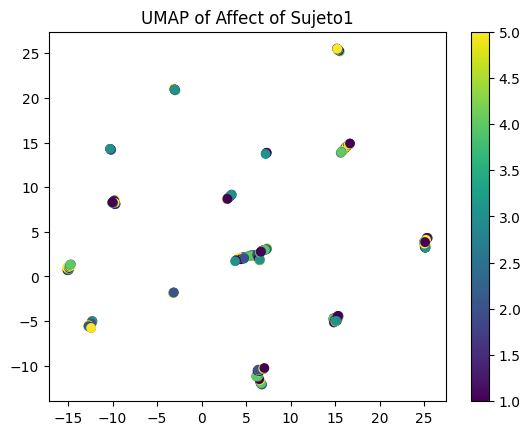

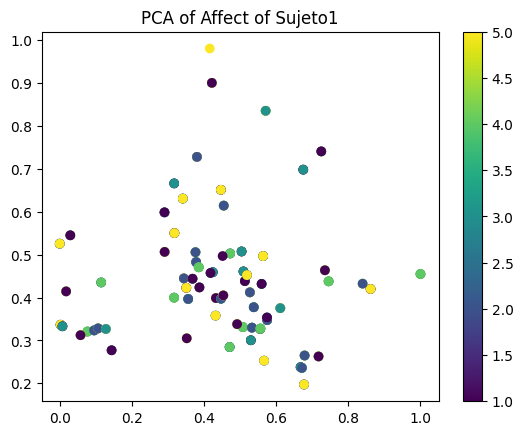

In [ ]:
reductions_affect = run_dimensionality_reduction(affect)

plot_embeddings(reductions_affect["umap2"], df_affect["stimulus"], 'UMAP of Affect of Sujeto1')
plot_embeddings(reductions_affect["pca5"], df_affect["stimulus"], 'PCA of Affect of Sujeto1')

Running PCA
Running UMAP


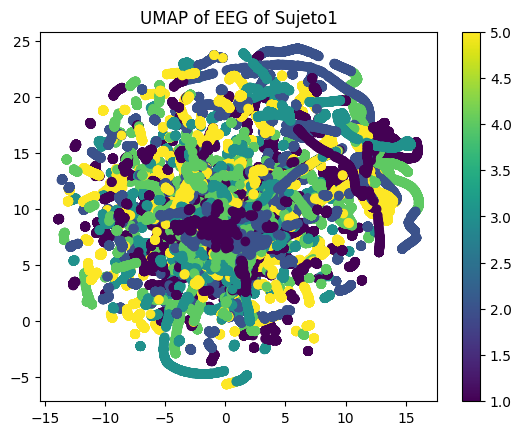

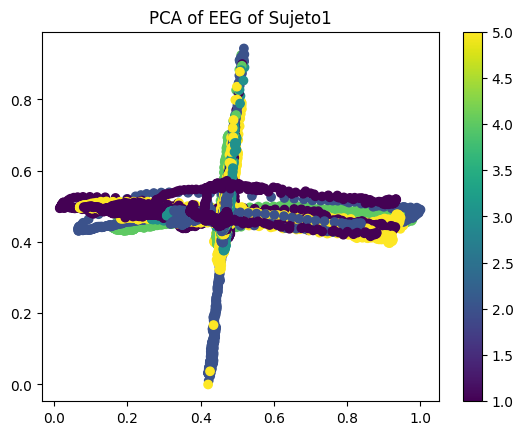

In [52]:
reductions_eeg = run_dimensionality_reduction(eeg)
plot_embeddings(reductions_eeg["umap2"], df_eeg["stimulus"] , 'UMAP of EEG of Sujeto1')
plot_embeddings(reductions_eeg["pca5"], df_eeg["stimulus"], 'PCA of EEG of Sujeto1')

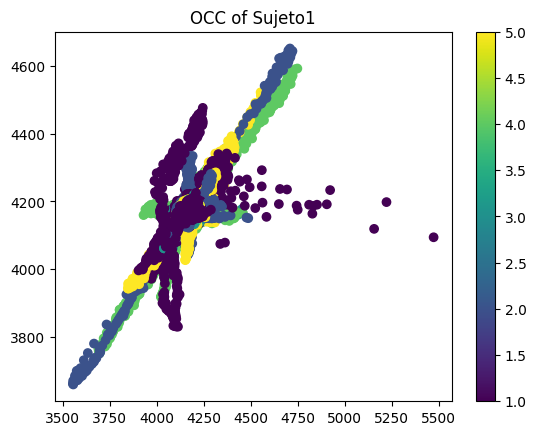

In [53]:
plot_embeddings(occ, df_occ["stimulus"], 'OCC of Sujeto1')